In [1]:
from config_paths import DATA, OUTPUT, INTERMEDIATE
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
from math import ceil
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

### 1. Paths to files

In [2]:
# 0) CONFIG: set your INTERMEDIATE folder and file pairs
# ─────────────────────────────────────────────────────────────

PAIRS = {
    "Atrato": dict(
        swot=INTERMEDIATE / "Store/Validation/csv/Atrato/Less_filters/Atrato_reg_bottom_error_simple.csv",
        bath=INTERMEDIATE / "Store/Binary_Masks/Atrato/Less_filters/Atrato_bathy_reg_bottom_error_simple.csv",
    ),
    "Cape_Fear": dict(
        swot=INTERMEDIATE / "Store/Validation/csv/Cape_fear/Cape_reg_bottom_error_simple.csv",
        bath=INTERMEDIATE / "Store/Binary_Masks/Cape_fear/Cape_bathy_reg_bottom_error_simple.csv",
    ),
    "Garonne": dict(
        swot=INTERMEDIATE / "Store/Validation/csv/Garonne/Garonne_reg_bottom_error_simple.csv",
        bath=INTERMEDIATE / "Store/Binary_Masks/Garonne/Garonne_bathy_reg_bottom_error_simple.csv",
    ),
    "Pee_Dee": dict(
        swot=INTERMEDIATE / "Store/Validation/csv/Pee_dee/Pee_dee_reg_bottom_error_simple.csv",
        bath=INTERMEDIATE / "Store/Binary_Masks/Pee_dee/Pee_bathy_reg_bottom_error_simple.csv",
    ),
    "Po": dict(
        swot=INTERMEDIATE / "Store/Validation/csv/Po/Po_reg_bottom_error_simple.csv",
        bath=INTERMEDIATE / "Store/Binary_Masks/Po/Po_bathy_reg_bottom_error_simple.csv",
    ),
    "Sacramento": dict(
        swot=INTERMEDIATE / "Store/Validation/csv/Sacramento/Sacramento_reg_bottom_error_simple.csv",
        bath=INTERMEDIATE / "Store/Binary_Masks/Sacramento/Sacramento_bathy_reg_bottom_error_simple.csv",
    ),
}

# Save outputs
OUT_DIR = INTERMEDIATE / "Store/Validation/compare_swot_bathy"
OUT_DIR.mkdir(parents=True, exist_ok=True)
SAVE_PLOTS = True
N_BOOT = 2000  # bootstrap replicates for CIs

In [6]:
def merge_csv(pairs: dict, swot_col: str, bath_col: str) -> dict:
    """Merge SWOT and Bathymetry CSV files on node_id column"""
    merged_dict = {}

    for river, paths in pairs.items():
        swot_df = pd.read_csv(paths["swot"], usecols=["node_id", swot_col])
        bath_df = pd.read_csv(paths["bath"], usecols=["node_id", bath_col])

        merged = pd.merge(
            swot_df,
            bath_df,
            on="node_id",
            how="inner",
        )

        merged = merged.groupby("node_id", as_index=False).first()
        merged_dict[river] = merged

    return merged_dict

In [7]:
merged_rivers = merge_csv(PAIRS, "slope_swot", "slope_bathy")
print(merged_rivers["Sacramento"].head())

          node_id  slope_swot  slope_bathy
0  77449300060171    0.037335     0.037654
1  77449300060181    0.042189     0.027386
2  77449300060191    0.066977     0.064405
3  77449300060241    0.013027     0.035113
4  77449300060251    0.025858     0.043105


In [120]:
def _sigfig(x, sig=2):
    """Format number with given significant figures."""
    if x == 0 or np.isnan(x):
        return "0"
    return f"{x:.{sig}g}"

def _resolve_cols(df: pd.DataFrame, swot_col: str, bath_col: str) -> tuple[str, str]:
    x_cands = [swot_col, f"{swot_col}_swot", f"{swot_col}_x"]
    y_cands = [bath_col, f"{bath_col}_bath", f"{bath_col}_y"]
    x = next((c for c in x_cands if c in df.columns), None)
    y = next((c for c in y_cands if c in df.columns), None)
    if x is None or y is None:
        non_key = [c for c in df.columns if c != "node_id"]
        if len(non_key) >= 2:
            if x is None: x = non_key[0]
            if y is None: y = non_key[1]
    if x is None or y is None:
        raise KeyError(f"Could not resolve columns. Have: {df.columns.tolist()}")
    return x, y


# 1) GRID OF PANELS
def plot_grid_by_river(
    merged_dict: dict[str, pd.DataFrame],
    swot_col: str,
    bath_col: str,
    ncols: int = 3,
    figsize_per_panel=(4.8, 4.2),
    scatter_size: int = 26,
    loglog: bool = False
):
    rivers = [r for r, df in merged_dict.items() if not df.empty]
    if not rivers:
        print("No non-empty rivers to plot.")
        return

    nrows = ceil(len(rivers) / ncols)
    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(figsize_per_panel[0]*ncols, figsize_per_panel[1]*nrows)
    )
    axes = np.atleast_1d(axes).ravel()

    all_x, all_y, resolved = [], [], {}
    for river in rivers:
        df = merged_dict[river]
        xname, yname = _resolve_cols(df, swot_col, bath_col)
        d = df[[xname, yname]].dropna()
        if loglog:
            d = d[(d[xname] > 0) & (d[yname] > 0)]
        if d.empty: continue
        resolved[river] = (xname, yname, d)
        all_x.append(d[xname].astype(float).values)
        all_y.append(d[yname].astype(float).values)

    all_x = np.concatenate(all_x)
    all_y = np.concatenate(all_y)
    vmin = np.nanmin([all_x.min(), all_y.min()])
    vmax = np.nanmax([all_x.max(), all_y.max()])
    pad = 0.02 * (vmax - vmin if vmax > vmin else 1.0)
    lims = (vmin - pad, vmax + pad)

    for ax, river in zip(axes, rivers):
        if river not in resolved:
            ax.axis("off"); continue
        xname, yname, d = resolved[river]
        x, y = d[xname].astype(float).values, d[yname].astype(float).values
        n = len(d)
        rho_s, p_s = spearmanr(x, y)
        r_p, p_p = pearsonr(x, y)

        ax.scatter(x, y, s=scatter_size, alpha=0.75, edgecolor="k", linewidth=0.4)
        ax.plot(lims, lims, "--", linewidth=1, color="gray")

        if loglog:
            ax.set_xscale("log")
            ax.set_yscale("log")

        ax.set_xlim(lims)
        ax.set_ylim(lims)
        ax.set_aspect("equal", adjustable="box")
        ax.set_title(river, fontsize=11)
        ax.set_xlabel(xname)
        ax.set_ylabel(yname)

        stats_txt = (
            f"ρ={_sigfig(rho_s)}, p={_sigfig(p_s)}\n"
            f"r={_sigfig(r_p)}, p={_sigfig(p_p)}\n"
            f"n={n}"
        )
        ax.legend(
            [Line2D([], [], color="none")],
            [stats_txt],
            loc="upper left",
            frameon=True,
            handlelength=0,
            handletextpad=0,
            borderaxespad=0.8,
            fontsize=9
        )

    for ax in axes[len(rivers):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


# 2) ALL RIVERS TOGETHER
def plot_all_rivers_together(
    merged_dict: dict[str, pd.DataFrame],
    swot_col: str,
    bath_col: str,
    figsize=(6.5, 5.8),
    scatter_size: int = 26,
    loglog: bool = False
):
    records, name_map = [], {}
    for river, df in merged_dict.items():
        if df.empty: continue
        try:
            xname, yname = _resolve_cols(df, swot_col, bath_col)
        except KeyError: continue
        d = df[[xname, yname]].dropna().copy()
        if loglog:
            d = d[(d[xname] > 0) & (d[yname] > 0)]
        if d.empty: continue
        d["__river__"] = river
        records.append(d)
        name_map[river] = (xname, yname)
    if not records:
        print("No data available across rivers."); return

    D = pd.concat(records, ignore_index=True)
    xcol, ycol = list(name_map.values())[0]
    x, y = D[xcol].astype(float).values, D[ycol].astype(float).values

    rho_s, p_s = spearmanr(x, y)
    r_p, p_p = pearsonr(x, y)
    total_n = len(D)

    vmin = np.nanmin([x.min(), y.min()])
    vmax = np.nanmax([x.max(), y.max()])
    pad = 0.02 * (vmax - vmin if vmax > vmin else 1.0)
    lims = (vmin - pad, vmax + pad)

    fig, ax = plt.subplots(figsize=figsize)
    rivers = D["__river__"].unique().tolist()
    color_map = {r: c for r, c in zip(rivers, plt.rcParams['axes.prop_cycle'].by_key()['color'])}

    for river in rivers:
        sub = D[D["__river__"] == river]
        ax.scatter(sub[xcol], sub[ycol],
                   s=scatter_size, alpha=0.75, edgecolor="k", linewidth=0.4,
                   label=f"{river} (n={len(sub)})",
                   c=color_map[river])

    ax.plot(lims, lims, "--", linewidth=1, color="gray")

    if loglog:
        ax.set_xscale("log")
        ax.set_yscale("log")

    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel(xcol)
    ax.set_ylabel(ycol)
    ax.set_title("All rivers")

    stats_txt = (
        f"ρ={_sigfig(rho_s)}, p={_sigfig(p_s)}\n"
        f"r={_sigfig(r_p)}, p={_sigfig(p_p)}\n"
        f"n={total_n}"
    )
    ax.legend(
        [Line2D([], [], color="none")],
        [stats_txt],
        loc="upper left",
        frameon=True,
        handlelength=0,
        handletextpad=0,
        borderaxespad=0.8,
        fontsize=9
    )

    # separate legend for rivers
    #ax.legend(loc="lower right", frameon=True, fontsize=9)
    plt.tight_layout()
    plt.show()


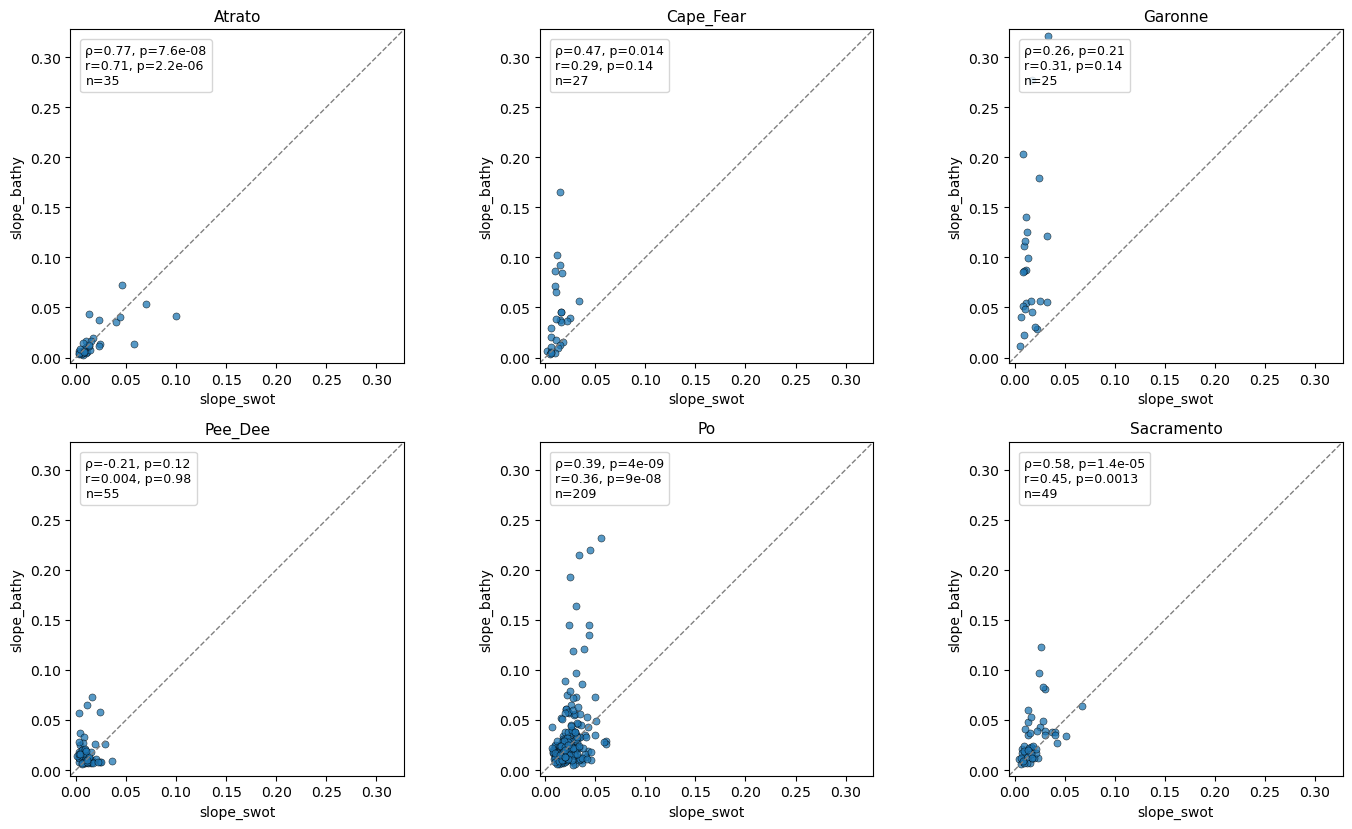

/var/folders/fg/t6lktxg91c5b91pyb0rk6x080000gn/T/ipykernel_19978/3803460216.py:164: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(lims)
/var/folders/fg/t6lktxg91c5b91pyb0rk6x080000gn/T/ipykernel_19978/3803460216.py:165: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(lims)


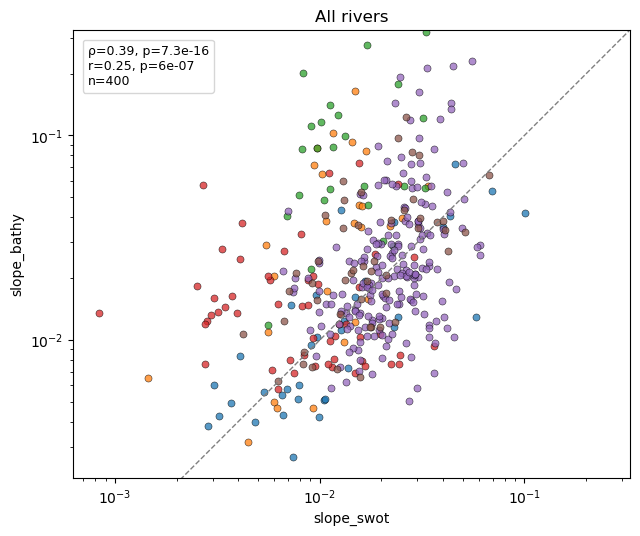

In [121]:
plot_grid_by_river(merged_rivers, swot_col="slope_SWOT", bath_col="slope_bathy", ncols=3, loglog=False)

plot_all_rivers_together(merged_rivers, swot_col="slope_SWOT", bath_col="slope_bathy", loglog=True)


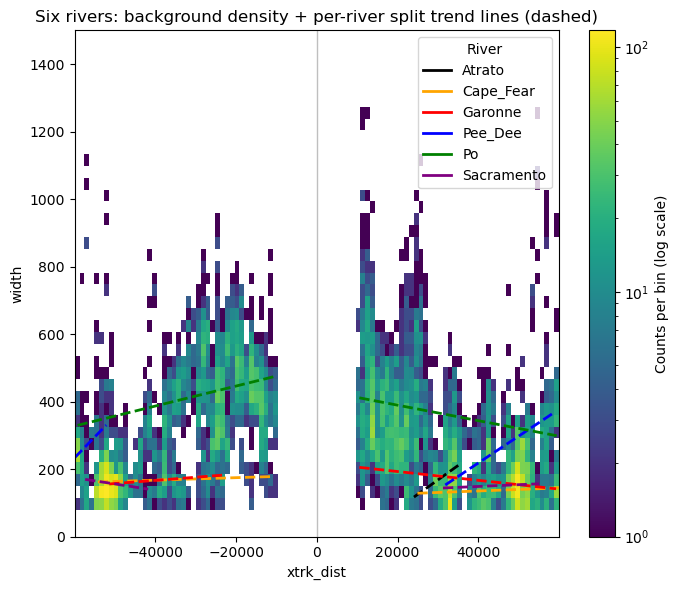

In [88]:
xcol = "width"
ycol = "xtrk_dist"

def _clean_numeric(a):
    a = pd.to_numeric(a, errors="coerce")
    return a.to_numpy()

# Manual river → color map
river_colors = {
    "Garonne": "red",
    "Pee_Dee": "blue",
    "Po": "green",
    "Sacramento": "purple",
    "Cape_Fear": "orange",
    "Atrato": "black"
}

# 1) Load all data once to define global bin edges
all_x, all_y = [], []
per_river = {}
for river, files in PAIRS.items():
    df = pd.read_csv(files["swot"])
    x = _clean_numeric(df[ycol])   # x-axis (xtrk_dist)
    y = _clean_numeric(df[xcol])   # y-axis (width)
    m = np.isfinite(x) & np.isfinite(y)
    x, y = x[m], y[m]
    per_river[river] = (x, y)
    if x.size and y.size:
        all_x.append(x); all_y.append(y)

all_x = np.concatenate(all_x)
all_y = np.concatenate(all_y)

# 2) Define common bin edges
xbins = 100
ybins = 100
xedges = np.linspace(np.nanmin(all_x), np.nanmax(all_x), xbins + 1)
yedges = np.linspace(np.nanmin(all_y), np.nanmax(all_y), ybins + 1)

# 3) Background heatmap
fig, ax = plt.subplots(figsize=(7, 6))
H_all, _, _ = np.histogram2d(all_x, all_y, bins=[xedges, yedges])

cmap = plt.cm.viridis.copy()
cmap.set_under("white")
im = ax.pcolormesh(
    xedges, yedges, H_all.T,
    norm=mcolors.LogNorm(vmin=1),
    cmap=cmap
)

# 4) Trend lines only (both sides dashed)
proxies = []
for river, (x, y) in per_river.items():
    color = river_colors.get(river, "black")  # fallback = black
    for mask in (x < 0, x > 0):
        xs, ys = x[mask], y[mask]
        if xs.size >= 2 and np.unique(xs).size >= 2:
            slope, intercept = np.polyfit(xs, ys, 1)
            xq_lo, xq_hi = np.nanpercentile(xs, [1, 99])
            if xq_hi > xq_lo:
                x_fit = np.linspace(xq_lo, xq_hi, 200)
                y_fit = slope * x_fit + intercept
                ax.plot(x_fit, y_fit, linestyle="--", linewidth=2, color=color)
    proxies.append(Line2D([0], [0], color=color, lw=2, label=river))

# divider at x=0
ax.axvline(0, color="k", lw=1, alpha=0.25)

# 5) Colorbar + legend
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Counts per bin (log scale)")
ax.legend(handles=proxies, title="River", loc="upper right")

ax.set_xlabel(ycol)
ax.set_ylabel(xcol)
ax.set_ylim(0, 1500)
ax.set_title("Six rivers: background density + per-river split trend lines (dashed)")
plt.tight_layout()
plt.show()

In [ ]:
def plot_single_river(PAIRS, river, bins=100, y_max=1500):
    """One plot for one river: background heatmap + split (x<0 / x>0) dashed trend lines."""
    df = pd.read_csv(PAIRS[river]["swot"])
    x = _clean_numeric(df["xtrk_dist"])   # x-axis
    y = _clean_numeric(df["width"])       # y-axis
    m = np.isfinite(x) & np.isfinite(y)
    x, y = x[m], y[m]
    if x.size == 0:
        raise RuntimeError(f"No valid data for {river}.")

    # bin edges
    xedges = np.linspace(np.nanmin(x), np.nanmax(x), bins + 1)
    yedges = np.linspace(np.nanmin(y), np.nanmax(y), bins + 1)

    # background heatmap
    fig, ax = plt.subplots(figsize=(7, 6))
    H, _, _ = np.histogram2d(x, y, bins=[xedges, yedges])

    cmap = plt.cm.viridis.copy()
    cmap.set_under("white")
    im = ax.pcolormesh(
        xedges, yedges, H.T,
        norm=mcolors.LogNorm(vmin=1),
        cmap=cmap
    )

    # dashed trend lines (x<0 and x>0)
    color = river_colors.get(river, "black")
    for mask in (x < 0, x > 0):
        xs, ys = x[mask], y[mask]
        if xs.size >= 2 and np.unique(xs).size >= 2:
            slope, intercept = np.polyfit(xs, ys, 1)
            xq_lo, xq_hi = np.nanpercentile(xs, [1, 99])
            if xq_hi > xq_lo:
                x_fit = np.linspace(xq_lo, xq_hi, 200)
                y_fit = slope * x_fit + intercept
                ax.plot(x_fit, y_fit, linestyle="--", linewidth=2, color=color)

    # divider at x=0
    ax.axvline(0, color="k", lw=1, alpha=0.25)

    # colorbar + labels
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("Counts per bin (log scale)")
    ax.set_xlabel("xtrk_dist")
    ax.set_ylabel("width")
    if y_max is not None:
        ax.set_ylim(0, y_max)
    ax.set_title(f"{river}: density + split trend lines (dashed)")
    plt.tight_layout()
    plt.show()


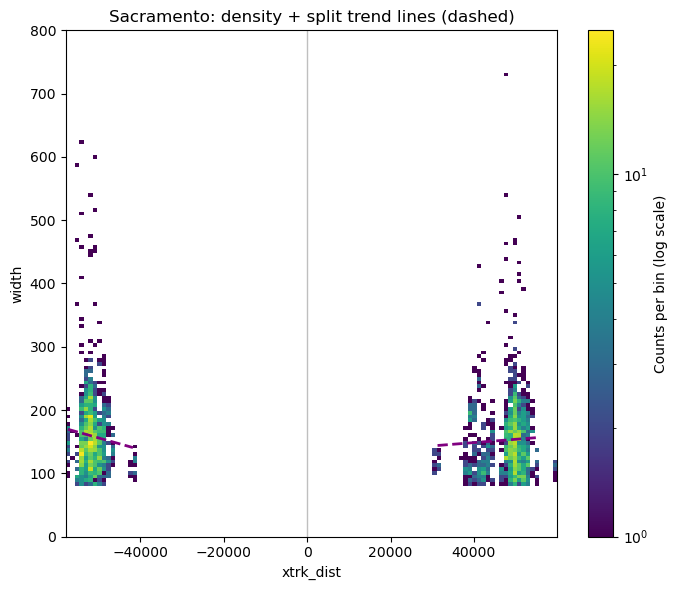

In [119]:
plot_single_river(PAIRS, "Sacramento", bins=110, y_max=800)

In [2]:
basins1 = pd.read_csv(OUTPUT / "Global_22_07_25/B61_huber_reg.csv")
basins2 = pd.read_csv(OUTPUT / "Global_22_07_25/B62_huber_reg.csv")
basins3 = pd.read_csv(OUTPUT / "Global_22_07_25/B74_huber_reg.csv")
basins4 = pd.read_csv(OUTPUT / "Global_22_07_25/B73_huber_reg.csv")
basins5 = pd.read_csv(OUTPUT / "Global_22_07_25/B23_huber_reg.csv")
basins6 = pd.read_csv(OUTPUT / "Global_22_07_25/B21_huber_reg.csv")
basins8 = pd.read_csv(OUTPUT / "Global_22_07_25/B45_huber_reg.csv")
basins9 = pd.read_csv(OUTPUT / "Global_22_07_25/B34_huber_reg.csv")
basins10 = pd.read_csv(OUTPUT / "Global_22_07_25/B53_huber_reg.csv")
basins11 = pd.read_csv(OUTPUT / "Global_22_07_25/B52_huber_reg.csv")
basins12 = pd.read_csv(OUTPUT / "Global_22_07_25/B13_huber_reg.csv")
basins13 = pd.read_csv(OUTPUT / "Global_22_07_25/B12_huber_reg.csv")

/var/folders/fg/t6lktxg91c5b91pyb0rk6x080000gn/T/ipykernel_22246/528197778.py:1: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  basins1 = pd.read_csv(OUTPUT / "Global_22_07_25/B61_huber_reg.csv")
/var/folders/fg/t6lktxg91c5b91pyb0rk6x080000gn/T/ipykernel_22246/528197778.py:2: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  basins2 = pd.read_csv(OUTPUT / "Global_22_07_25/B62_huber_reg.csv")
/var/folders/fg/t6lktxg91c5b91pyb0rk6x080000gn/T/ipykernel_22246/528197778.py:3: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  basins3 = pd.read_csv(OUTPUT / "Global_22_07_25/B74_huber_reg.csv")
/var/folders/fg/t6lktxg91c5b91pyb0rk6x080000gn/T/ipykernel_22246/528197778.py:4: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  basins4 = pd.read_csv(OUTPUT / "Global_22_07_25/B73_huber_re

In [4]:
# merge all into one
basins = pd.concat(
    [basins1, basins2, basins3, basins4, basins5,
     basins6, basins8, basins9, basins10,
     basins11, basins12, basins13],
    ignore_index=True   # reindex rows 0..N-1
)
len(basins)

9834161

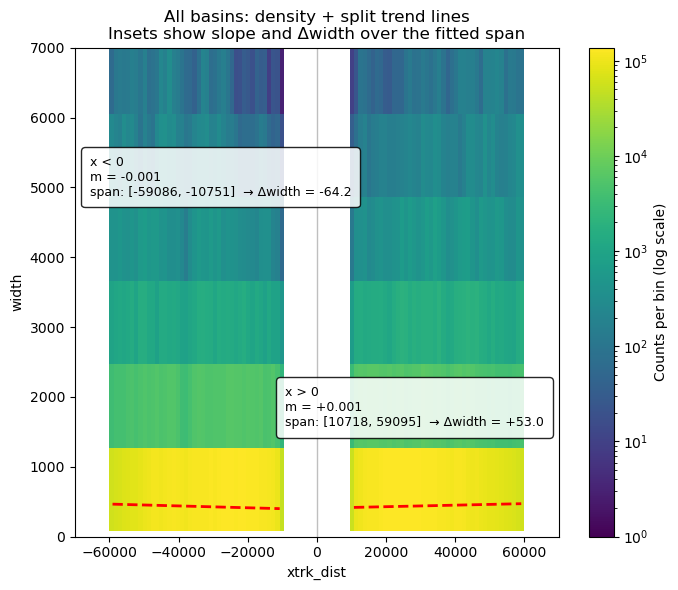

In [11]:
# --- columns ---
xcol = "width"        # y-axis
ycol = "xtrk_dist"    # x-axis

def _clean_numeric(a):
    return pd.to_numeric(a, errors="coerce").to_numpy()

# basins = pd.read_csv(...)

x = _clean_numeric(basins[ycol])
y = _clean_numeric(basins[xcol])
m = np.isfinite(x) & np.isfinite(y)
x, y = x[m], y[m]

# ---- choose how to define the line's span ----
USE_PERCENTILES = True
PCT_LO, PCT_HI = 1, 99   # robust endpoints if True

def span(xs):
    """Return (x_start, x_end) for the fitted line span."""
    if USE_PERCENTILES:
        lo, hi = np.nanpercentile(xs, [PCT_LO, PCT_HI])
    else:
        lo, hi = np.nanmin(xs), np.nanmax(xs)
    return float(lo), float(hi)

# --- background density ---
xbins = 100
ybins = 100
xedges = np.linspace(np.nanmin(x), np.nanmax(x), xbins + 1)
yedges = np.linspace(np.nanmin(y), np.nanmax(y), ybins + 1)

fig, ax = plt.subplots(figsize=(7, 6))
H, _, _ = np.histogram2d(x, y, bins=[xedges, yedges])
cmap = plt.cm.viridis.copy()
cmap.set_under("white")
im = ax.pcolormesh(xedges, yedges, H.T, norm=mcolors.LogNorm(vmin=1), cmap=cmap)

# --- trend lines + compute increment (Δwidth) from start to end of each fitted line ---
left_info  = "x < 0\n"
right_info = "x > 0\n"

for side_label, mask, box in (("x<0", x < 0, "left"), ("x>0", x > 0, "right")):
    xs, ys = x[mask], y[mask]
    if xs.size >= 2 and np.unique(xs).size >= 2:
        # fit y = m x + b
        m_hat, b_hat = np.polyfit(xs, ys, 1)
        x0, x1 = span(xs)
        if x1 > x0:
            # draw line
            x_fit = np.linspace(x0, x1, 200)
            y_fit = m_hat * x_fit + b_hat
            ax.plot(x_fit, y_fit, linestyle="--", linewidth=2, color="red")

            # increment from start to end of the fitted span
            y_start = m_hat * x0 + b_hat
            y_end   = m_hat * x1 + b_hat
            dwidth  = y_end - y_start   # <-- THIS is the increment you want

            # add to inset text
            line = (
                f"m = {m_hat:+.3f}\n"
                f"span: [{x0:.0f}, {x1:.0f}]  → Δwidth = {dwidth:+.1f}"
            )
            if box == "left":
                left_info += line
            else:
                right_info += line
    else:
        if box == "left":
            left_info += "(insufficient data)"
        else:
            right_info += "(insufficient data)"

# divider at x=0
ax.axvline(0, color="k", lw=1, alpha=0.25)

# insets
left_box = AnchoredText(
    left_info, loc="upper left", prop=dict(size=9),
    frameon=True, bbox_to_anchor=(0.01, 0.80),   # ⬅ y=0.80 instead of 0.99
    bbox_transform=ax.transAxes, borderpad=0.4
)
left_box.patch.set_boxstyle("round,pad=0.3")
left_box.patch.set_alpha(0.85)
ax.add_artist(left_box)

# right box: lower right
right_box = AnchoredText(
    right_info, loc="lower right", prop=dict(size=9),
    frameon=True, bbox_to_anchor=(0.99, 0.20),   # ⬅ y=0.20 moves it to bottom
    bbox_transform=ax.transAxes, borderpad=0.4
)
right_box.patch.set_boxstyle("round,pad=0.3")
right_box.patch.set_alpha(0.85)
ax.add_artist(right_box)

# labels & colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Counts per bin (log scale)")
ax.set_xlabel(ycol); ax.set_ylabel(xcol)
ax.set_ylim(0, 7000); ax.set_xlim(-70000, 70000)
ax.set_title("All basins: density + split trend lines\nInsets show slope and Δwidth over the fitted span")
plt.tight_layout(); plt.show()

In [74]:
# --------- helpers ---------
def _clean_numeric(a):
    return pd.to_numeric(a, errors="coerce").to_numpy()

def _fit_line(xs, ys):
    """Return (slope, intercept, x_lo, x_hi) using robust 1–99% x-range; None if not fit."""
    if xs.size < 2 or np.unique(xs).size < 2:
        return None
    slope, intercept = np.polyfit(xs, ys, 1)
    x_lo, x_hi = np.nanpercentile(xs, [1, 99])
    if not (x_hi > x_lo):
        x_lo, x_hi = float(np.nanmin(xs)), float(np.nanmax(xs))
    return slope, intercept, float(x_lo), float(x_hi)

# --------- main function ---------
def plot_scatter_node_with_inset(
    PAIRS, river, node_id=None,
    y_max=1500, x_limits=None,
    pct_window=(5, 95),                   # zoom window percentiles for main data
    inset_size=("38%", "38%"),            # width/height of inset
    inset_loc="upper right",              # 'upper right' | 'upper left' | 'lower right' | 'lower left'
    inset_anchor=None,                    # if set: (x, y, w, h) in axes coords
    connectors=(2, 4),                    # corners used by mark_inset
    scatter_kwargs=None                   # override scatter styling
):
    """
    Pretty scatter of xtrk_dist (X) vs width (Y) for a river (optionally filtered by node_id),
    with a zoomed inset that includes dashed trend lines for x<0 and x>0.
    """
    # --- load & filter ---
    df = pd.read_csv(PAIRS[river]["swot"])
    if node_id is not None:
        if isinstance(node_id, (list, tuple, set)):
            df = df[df["node_id"].isin(node_id)]
        else:
            df = df[df["node_id"] == node_id]
    if df.empty:
        raise RuntimeError(f"No data for {river}, node_id={node_id}")

    x = _clean_numeric(df["xtrk_dist"])
    y = _clean_numeric(df["width"])
    m = np.isfinite(x) & np.isfinite(y)
    x, y = x[m], y[m]
    if x.size == 0:
        raise RuntimeError("No finite points after cleaning")

    # --- base scatter ---
    if scatter_kwargs is None:
        scatter_kwargs = dict(s=10, alpha=0.9, c="tab:blue", edgecolor="none")

    fig, ax = plt.subplots(figsize=(7, 6))
    ax.scatter(x, y, **scatter_kwargs)
    ax.axvline(0, color="k", lw=1, alpha=0.9)

    ax.set_xlabel("xtrk_dist")
    ax.set_ylabel("width")
    if y_max is not None:
        ax.set_ylim(0, y_max)
    if x_limits is not None:
        ax.set_xlim(*x_limits)

    title_extra = f" (node_id={node_id})" if node_id is not None else ""
    ax.set_title(f"{river} — {title_extra}")

    # --- compute zoom window from percentiles ---
    p_lo, p_hi = pct_window
    x_lo, x_hi = np.nanpercentile(x, [p_lo, p_hi])
    y_lo, y_hi = np.nanpercentile(y, [p_lo, p_hi])
    # small padding
    pad_x = 0.03 * (x_hi - x_lo) if x_hi > x_lo else 1.0
    pad_y = 0.03 * (y_hi - y_lo) if y_hi > y_lo else 1.0
    zx0, zx1 = x_lo - pad_x, x_hi + pad_x
    zy0, zy1 = y_lo - pad_y, y_hi + pad_y

    # --- inset axes placement ---
    if inset_anchor is None:
        axins = inset_axes(
            ax, width=inset_size[0], height=inset_size[1],
            loc=inset_loc, borderpad=1.0
        )
    else:
        axins = inset_axes(
            ax, width=inset_size[0], height=inset_size[1],
            bbox_to_anchor=inset_anchor, bbox_transform=ax.transAxes,
            loc="lower left", borderpad=0.4
        )

    axins.set_facecolor((1, 1, 1, 0.90))
    axins.set_zorder(3)

    # --- inset scatter ---
    axins.scatter(x, y, s=6, alpha=0.9, c=scatter_kwargs.get("c", "tab:blue"), edgecolor="none")
    axins.set_xlim(zx0, zx1)
    axins.set_ylim(zy0, zy1)
    axins.axvline(0, color="k", lw=1, alpha=0.9)
    axins.set_xlabel("xtrk_dist", fontsize=8)
    axins.set_ylabel("width", fontsize=8)
    axins.tick_params(axis="both", labelsize=7)
    axins.set_title("zoom + trends", fontsize=8, pad=2)

    # --- dashed trend lines inside inset ---
    for xmask in (x < 0, x > 0):
        xs, ys = x[xmask], y[xmask]
        fit = _fit_line(xs, ys)
        if fit is None:
            continue
        slope, intercept, xlo_side, xhi_side = fit
        lo = max(min(xlo_side, xhi_side), zx0)
        hi = min(max(xlo_side, xhi_side), zx1)
        if hi > lo:
            x_fit = np.linspace(lo, hi, 200)
            y_fit = slope * x_fit + intercept
            axins.plot(x_fit, y_fit, linestyle="--", linewidth=1.5, color="red")

    # --- rectangle connectors on main plot ---
    try:
        mark_inset(ax, axins, loc1=connectors[0], loc2=connectors[1],
                   fc="none", ec="crimson", lw=1.2, alpha=0.2)
    except Exception:
        import matplotlib.patches as patches
        rect = patches.Rectangle((zx0, zy0), zx1 - zx0, zy1 - zy0,
                                 fill=False, ec="crimson", lw=1.2, alpha=0.2)
        ax.add_patch(rect)

    plt.tight_layout()
    plt.show()



/var/folders/fg/t6lktxg91c5b91pyb0rk6x080000gn/T/ipykernel_22246/998587615.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


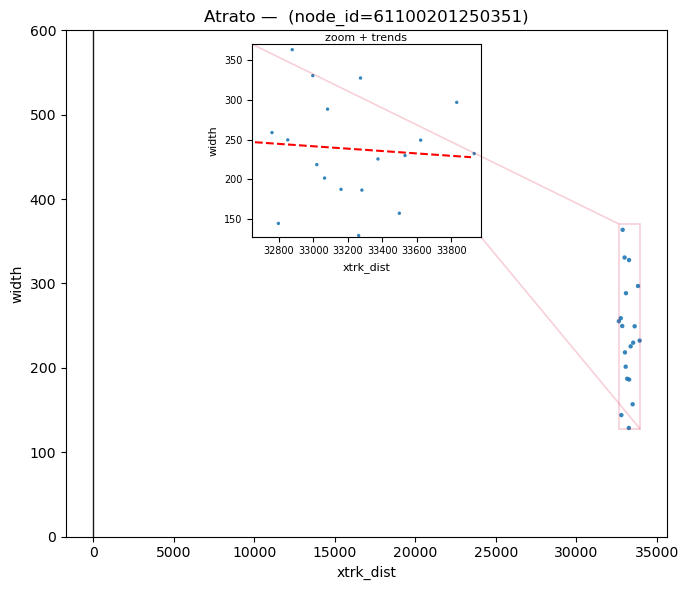

In [78]:
plot_scatter_node_with_inset(PAIRS, "Atrato", node_id=61100201250351, y_max=600,  pct_window=(2, 100),inset_loc="upper center")

In [3]:
# Try SciPy for p-values; fall back to pandas if unavailable
try:
    from scipy.stats import pearsonr, spearmanr
    _HAVE_SCIPY = True
except Exception:
    _HAVE_SCIPY = False

# --------- helpers (your originals kept) ---------
def _clean_numeric(a):
    return pd.to_numeric(a, errors="coerce").to_numpy()

def _fit_line(xs, ys):
    """Return (slope, intercept, x_lo, x_hi) using robust 1–99% x-range; None if not fit."""
    if xs.size < 2 or np.unique(xs).size < 2:
        return None
    slope, intercept = np.polyfit(xs, ys, 1)
    x_lo, x_hi = np.nanpercentile(xs, [1, 99])
    if not (x_hi > x_lo):
        x_lo, x_hi = float(np.nanmin(xs)), float(np.nanmax(xs))
    return slope, intercept, float(x_lo), float(x_hi)

def _corr_stats(xs, ys):
    xs = np.asarray(xs); ys = np.asarray(ys)
    m = np.isfinite(xs) & np.isfinite(ys)
    xs, ys = xs[m], ys[m]
    n = xs.size
    if n < 3:
        return {"n": n, "pearson": (np.nan, np.nan), "spearman": (np.nan, np.nan)}
    if _HAVE_SCIPY:
        try:
            r_p, p_p = pearsonr(xs, ys)
        except Exception:
            r_p, p_p = (np.nan, np.nan)
        try:
            r_s, p_s = spearmanr(xs, ys)
        except Exception:
            r_s, p_s = (np.nan, np.nan)
    else:
        r_p = pd.Series(xs).corr(pd.Series(ys), method="pearson")
        r_s = pd.Series(xs).corr(pd.Series(ys), method="spearman")
        p_p = np.nan; p_s = np.nan
    return {"n": n, "pearson": (r_p, p_p), "spearman": (r_s, p_s)}

# --------- GRID version using your inset pattern ---------
def plot_nodes_grid_with_inset(
    PAIRS, river,
    node_ids=None,                 # iterable of node_ids; if None, sample fraction
    sample_frac=0.25,              # fraction of UNIQUE node_id to sample when node_ids is None
    sample_seed=42,
    max_panels=12,                 # cap grid size
    ncols=2,                       # two columns requested
    y_max=1500, x_limits=None,
    pct_window=(5, 95),            # zoom window percentiles
    inset_size=("38%", "38%"),     # inset size per panel
    inset_loc="upper right",       # placement inside each panel
    connectors=(2, 4),             # mark_inset corners
    scatter_kwargs=None,           # same style across panels
    show_p=False                   # include p-values in text box
):
    """
    Grid of scatterplots (xtrk_dist vs width) per node_id (2 columns).
    Each panel has a zoomed inset (like your single-plot function) with dashed trend lines,
    and a small text box at the upper-left of the MAIN panel showing r and ρ.
    """
    # Load all data for the river
    df_all = pd.read_csv(PAIRS[river]["swot"])
    if df_all.empty:
        raise RuntimeError(f"No data for river={river}")

    # Choose node_ids
    if node_ids is None:
        unique_nodes = pd.Series(df_all["node_id"].dropna().unique())
        if unique_nodes.empty:
            raise RuntimeError("No node_id values found.")
        rng = np.random.default_rng(sample_seed)
        k_target = max(1, int(np.floor(sample_frac * len(unique_nodes))))
        k = min(k_target, max_panels)
        node_ids = rng.choice(unique_nodes.values, size=k, replace=False)
    else:
        node_ids = list(dict.fromkeys(node_ids))
        if len(node_ids) > max_panels:
            node_ids = node_ids[:max_panels]

    n = len(node_ids)
    if n == 0:
        raise RuntimeError("No node_ids selected.")

    # Layout
    ncols = max(1, ncols)
    nrows = int(np.ceil(n / ncols))

    if scatter_kwargs is None:
        scatter_kwargs = dict(s=10, alpha=0.9, c="tab:blue", edgecolor="none")  # your defaults

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                             figsize=(5.2*ncols, 4.2*nrows))
    axes = np.atleast_1d(axes).ravel()

    last_ax = -1
    for i, node in enumerate(node_ids):
        ax = axes[i]
        dfi = df_all[df_all["node_id"] == node]
        if dfi.empty:
            ax.set_visible(False); continue

        x = _clean_numeric(dfi["xtrk_dist"])
        y = _clean_numeric(dfi["width"])
        m = np.isfinite(x) & np.isfinite(y)
        x, y = x[m], y[m]
        if x.size < 3:
            ax.set_visible(False); continue

        # --- MAIN scatter (same style for all panels) ---
        ax.scatter(x, y, **scatter_kwargs)
        ax.axvline(0, color="k", lw=1, alpha=0.9)
        ax.set_title(f"node_id = {node}", fontsize=10)
        ax.set_xlabel("xtrk_dist", fontsize=9)
        ax.set_ylabel("width", fontsize=9)
        if y_max is not None:
            ax.set_ylim(0, y_max)
        if x_limits is not None:
            ax.set_xlim(*x_limits)

        # --- Correlations (overall per node) shown as small INSET TEXT (upper-left of main) ---
        stats = _corr_stats(x, y)
        r,  p_r  = stats["pearson"]
        rho, p_rho = stats["spearman"]
        if show_p:
            txt = (f"r={r:+.3f} (p={p_r:.1e})\n"
                   f"ρ={rho:+.3f} (p={p_rho:.1e})")
        else:
            txt = (f"r={r:+.3f}\n"
                   f"ρ={rho:+.3f}")
        ax.text(0.02, 0.98, txt, transform=ax.transAxes, va="top", ha="left",
                fontsize=8, color="black",
                bbox=dict(facecolor="white", alpha=0.95, edgecolor="0.5", boxstyle="round,pad=0.25"))

        # --- compute zoom window from percentiles (like your code) ---
        p_lo, p_hi = pct_window
        x_lo, x_hi = np.nanpercentile(x, [p_lo, p_hi])
        y_lo, y_hi = np.nanpercentile(y, [p_lo, p_hi])
        pad_x = 0.03 * (x_hi - x_lo) if x_hi > x_lo else 1.0
        pad_y = 0.03 * (y_hi - y_lo) if y_hi > y_lo else 1.0
        zx0, zx1 = x_lo - pad_x, x_hi + pad_x
        zy0, zy1 = y_lo - pad_y, y_hi + pad_y

        # --- INSET axes (same as your pattern) ---
        axins = inset_axes(ax, width=inset_size[0], height=inset_size[1],
                           loc=inset_loc, borderpad=1.0)
        axins.set_facecolor((1, 1, 1, 0.90))
        axins.set_zorder(3)

        # inset scatter
        axins.scatter(x, y, s=6, alpha=scatter_kwargs.get("alpha", 0.9),
                      c=scatter_kwargs.get("c", "tab:blue"), edgecolor="none")
        axins.set_xlim(zx0, zx1)
        axins.set_ylim(zy0, zy1)
        axins.axvline(0, color="k", lw=1, alpha=0.9)
        axins.set_xlabel("xtrk_dist", fontsize=8)
        axins.set_ylabel("width", fontsize=8)
        axins.tick_params(axis="both", labelsize=7)
        axins.set_title("zoom + trends", fontsize=8, pad=2)

        # dashed trend lines (x<0, x>0) inside inset, clipped to zoom
        for xmask in (x < 0, x > 0):
            xs, ys = x[xmask], y[xmask]
            fit = _fit_line(xs, ys)
            if fit is None:
                continue
            slope, intercept, xlo_side, xhi_side = fit
            lo = max(min(xlo_side, xhi_side), zx0)
            hi = min(max(xlo_side, xhi_side), zx1)
            if hi > lo:
                xf = np.linspace(lo, hi, 200)
                axins.plot(xf, slope*xf + intercept, linestyle="--", linewidth=1.5, color="red")

        # connectors (STRONG alpha as you wanted)
        try:
            mark_inset(ax, axins, loc1=connectors[0], loc2=connectors[1],
                       fc="none", ec="crimson", lw=1.2, alpha=0.2)
        except Exception:
            import matplotlib.patches as patches
            rect = patches.Rectangle((zx0, zy0), zx1 - zx0, zy1 - zy0,
                                     fill=False, ec="crimson", lw=1.2, alpha=0.2)
            ax.add_patch(rect)

        last_ax = i

    # hide unused axes
    for j in range(last_ax + 1, len(axes)):
        axes[j].set_visible(False)

    fig.suptitle(f"{river} — 25% sampled (r, ρ in panel)", fontsize=14, y=0.995)
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

/var/folders/fg/t6lktxg91c5b91pyb0rk6x080000gn/T/ipykernel_28012/3449603988.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 0.97])


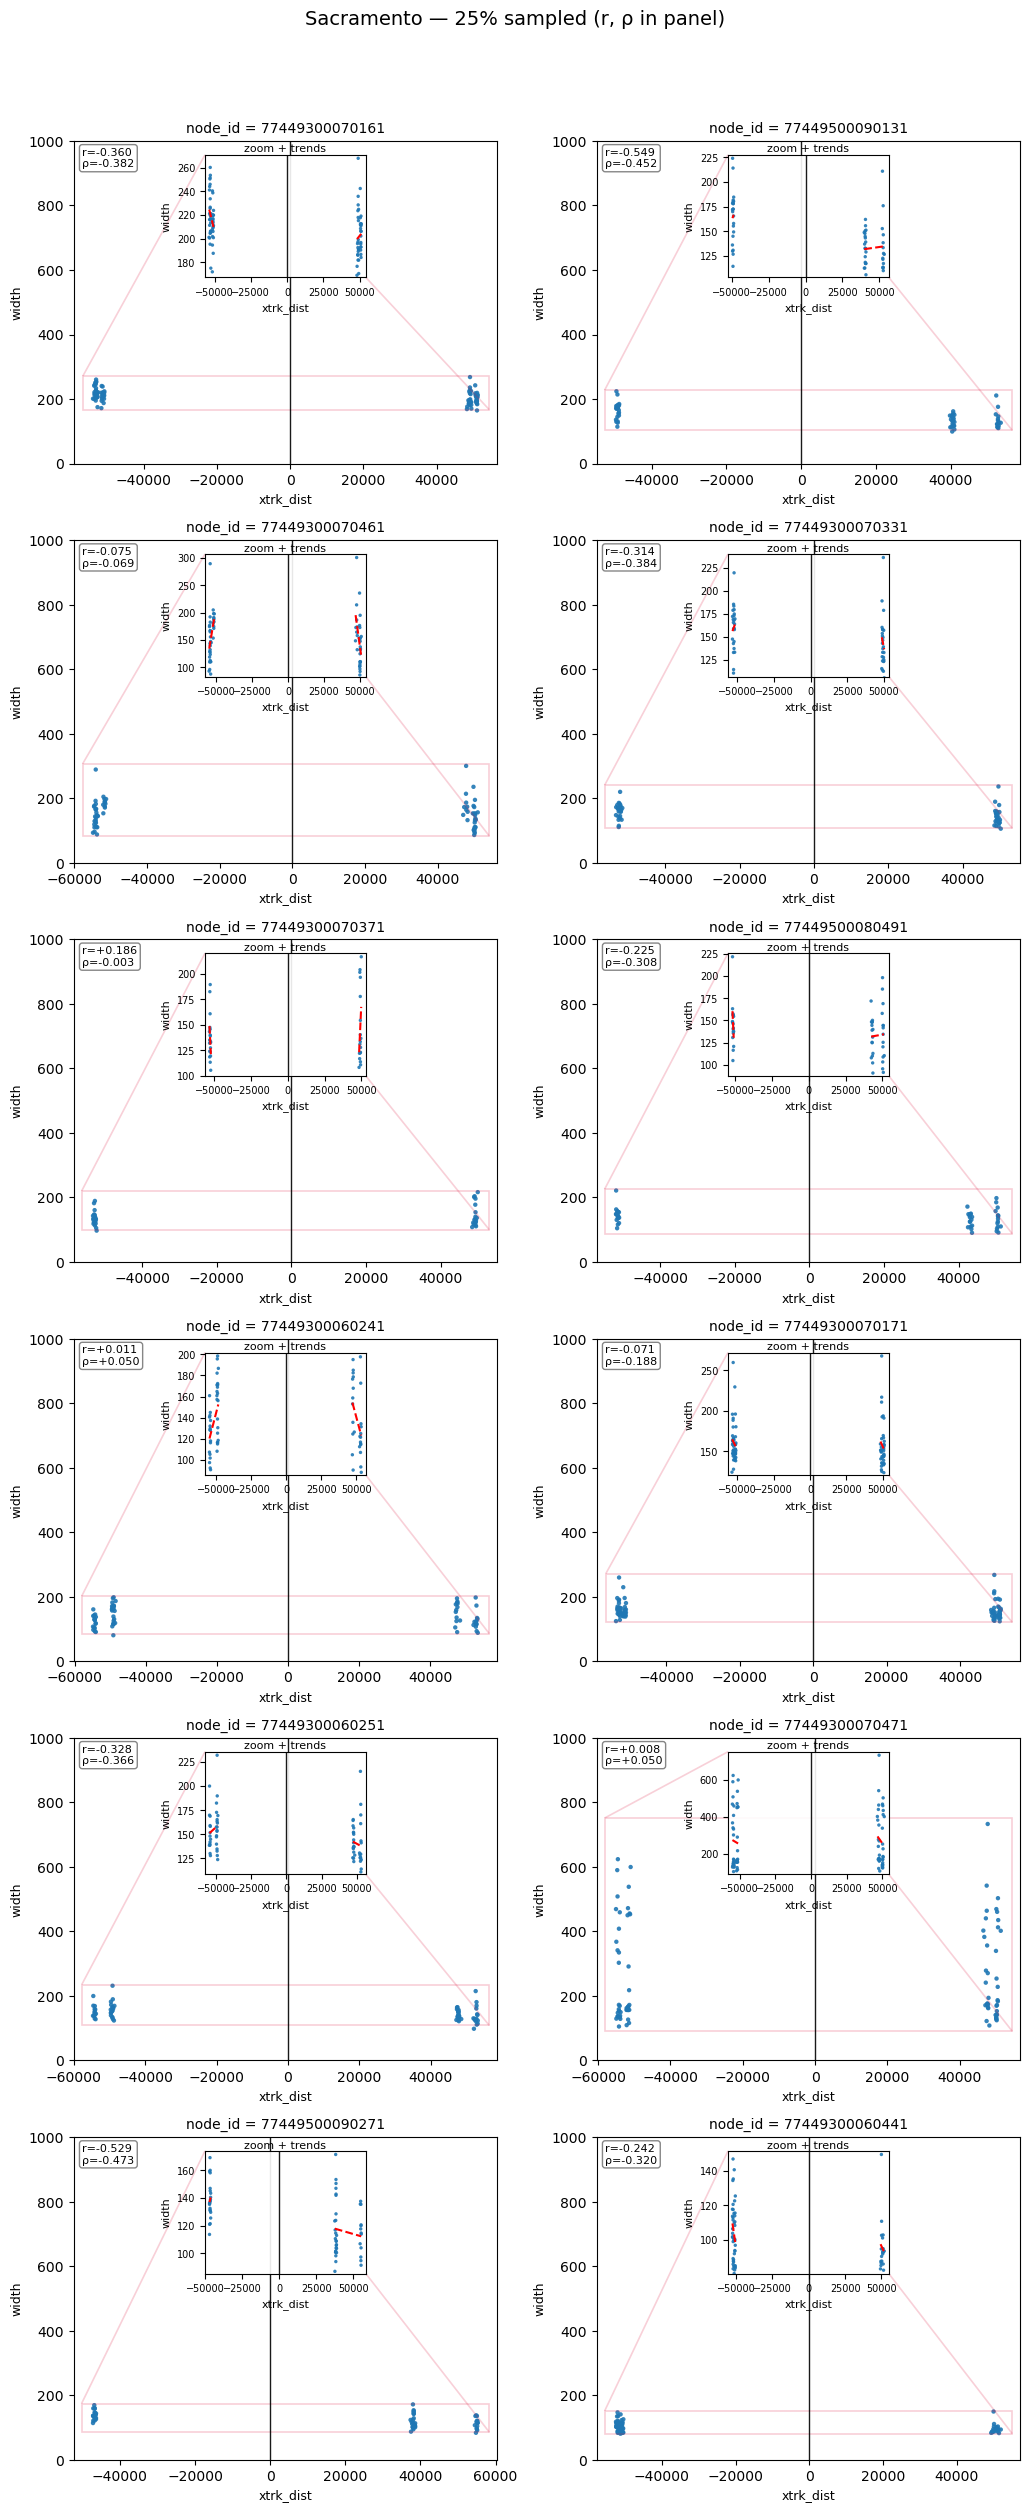

In [5]:
plot_nodes_grid_with_inset(PAIRS, "Sacramento",  y_max=1000,  pct_window=(2, 100),inset_loc="upper center")